In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from scipy.stats import norm
import os

In [2]:
# make grid of azimuth (theta) and elevation (alpha) coordinates
res = 20
    
# full res lattice sampling azimuth and elevation
theta_mat,alpha_mat = np.meshgrid(np.linspace(-np.pi,np.pi,int(res),endpoint=False),
                                np.linspace(-np.pi/2,np.pi/2,int(res/2),endpoint=False))

# flatten matrices
thetas = theta_mat.flatten()
alphas = alpha_mat.flatten()

# remove points where alpha = -pi/2
thetas = thetas[alphas > -np.pi/2]
alphas = alphas[alphas > -np.pi/2]

# generate masks for subsampling visual field

# indices for full field sampling
fullfield_inds = np.arange(0,np.size(thetas),2)

for i in np.arange(0,90,20):
    fullfield_inds[i:i+10] = fullfield_inds[i:i+10]+1

# subset center on foci and antifoci for Vz masks
r = np.pi*.4
foci = np.logical_or(np.sqrt(thetas**2+alphas**2)<r,np.sqrt((thetas+np.pi)**2+alphas**2)<r)
foci = np.logical_or(foci,np.sqrt((thetas-np.pi)**2+alphas**2)<r)
foci_inds = np.squeeze(np.where(foci == True))
antifoci_inds = np.squeeze(np.where(foci == False))

print('total nsamples =', np.size(thetas))
print('full field nsamples =', np.size(fullfield_inds))
print('foci nsamples =', np.size(foci_inds))
print('antifoci nsamples =', np.size(antifoci_inds))

inds_all = [fullfield_inds,foci_inds,antifoci_inds]
thetatitles = ['fullfield','foci','anti-foci']
veltitles = ['Vx','Vy','Vz','Wx','Wy','Wz']


os.makedirs('./global_plots',exist_ok=True)

total nsamples = 180
full field nsamples = 90
foci nsamples = 90
antifoci nsamples = 90


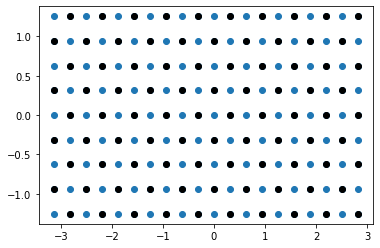

In [3]:
# show that full field sampling is taking every other sample

plt.scatter(thetas,alphas)
plt.scatter(thetas[fullfield_inds],alphas[fullfield_inds],color='black')

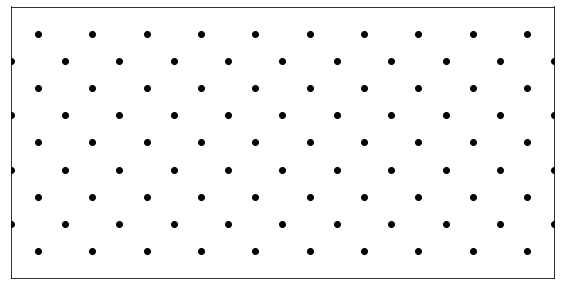

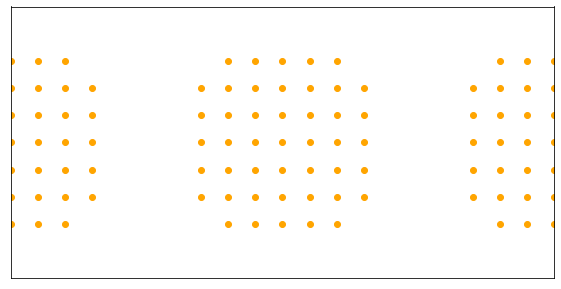

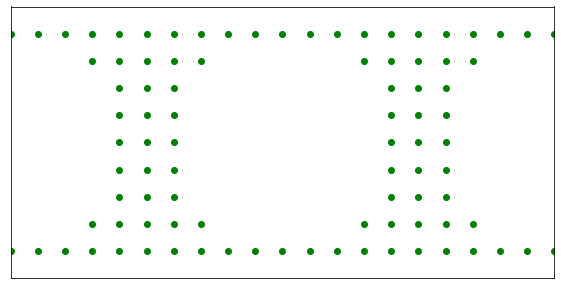

In [4]:
# visualize mask samples - Vz

thetas_ff = thetas.copy()
thetas_ff = thetas[fullfield_inds]
alphas_ff = alphas.copy()
alphas_ff = alphas[fullfield_inds]

plt.figure(figsize=(10,5))
ax = plt.axes()
plt.axis('equal')
plt.scatter(np.append(thetas_ff,-thetas_ff[thetas_ff<-3]),np.append(alphas_ff,alphas_ff[thetas_ff<-3]),color='black')
ax.set_box_aspect(1/2)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi/2,np.pi/2)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.savefig(f'./global_plots/final_fullfield_sampling.png', format='png',dpi=300)

thetas_foci = thetas.copy()
thetas_foci = thetas[foci_inds]
alphas_foci = alphas.copy()
alphas_foci = alphas[foci_inds]

plt.figure(figsize=(10,5))
ax = plt.axes()
plt.axis('equal')
plt.scatter(np.append(thetas_foci,-thetas_foci[thetas_foci<-3]),np.append(alphas_foci,alphas_foci[thetas_foci<-3]),color='orange')
ax.set_box_aspect(1/2)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi/2,np.pi/2)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.savefig(f'./global_plots/final_foci_sampling.png', format='png',dpi=300)

thetas_antifoci = thetas.copy()
thetas_antifoci = thetas[antifoci_inds]
alphas_antifoci = alphas.copy()
alphas_antifoci = alphas[antifoci_inds]

plt.figure(figsize=(10,5))
ax = plt.axes()
plt.axis('equal')
plt.scatter(np.append(thetas_antifoci,-thetas_antifoci[thetas_antifoci<-3]),np.append(alphas_antifoci,alphas_antifoci[thetas_antifoci<-3]),color='green')
ax.set_box_aspect(1/2)
plt.xlim(-np.pi,np.pi)
plt.ylim(-np.pi/2,np.pi/2)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)

plt.savefig(f'./global_plots/final_antifoci_sampling.png', format='png',dpi=300)




In [6]:
# function for determining scene depth geometry
def nearness(geometry='sphere',theta=thetas,alpha=alphas,r=1):
    if geometry == 'sphere':
        mu = 1/r*np.ones_like(theta)
    elif geometry == 'floor':
        mu = np.abs(np.sin(alpha))/r * (alpha < 0)
    return mu

# equations slightly modified (signs and axis labels changed) from
# eqn 2.13 and following matrices in
# http://www.cds.caltech.edu/~murray/preprints/humbert05-phd.pdf
def tangentialflow(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,geometry='sphere',theta=thetas,alpha=alphas,r=1,theta0=0,alpha0=0):
    mu = nearness(geometry=geometry,theta=theta,alpha=alpha,r=r)
    flow_horiz = -np.sin(alpha)*np.cos(theta)*Wz + \
                 np.sin(alpha)*np.sin(theta)*Wx + \
                 -np.cos(alpha)*Wy + \
                 mu*(np.sin(theta)*Vz + np.cos(theta)*Vx)
    flow_vert = np.sin(theta)*Wz + \
                np.cos(theta)*Wx + \
                mu*(np.sin(alpha)*np.cos(theta)*Vz + \
                          -np.sin(alpha)*np.sin(theta)*Vx + \
                          np.cos(alpha)*Vy)
    return flow_horiz, flow_vert


In [7]:
# predict velocity from flow with weighted least squares
def getvel(flow,theta=thetas,alpha=alphas,geometry='sphere',DOFs=6,weights=0):
    
    # if no weights were given, assume uniform
    if np.size(weights) == 1:
        weights=np.ones(len(theta))
        
    vxtemplate = np.ndarray.flatten(np.array(tangentialflow(Vx=1,theta=theta,alpha=alpha,geometry=geometry)))
    vytemplate = np.ndarray.flatten(np.array(tangentialflow(Vy=1,theta=theta,alpha=alpha,geometry=geometry)))
    vztemplate = np.ndarray.flatten(np.array(tangentialflow(Vz=1,theta=theta,alpha=alpha,geometry=geometry)))
    wxtemplate = np.ndarray.flatten(np.array(tangentialflow(Wx=1,theta=theta,alpha=alpha,geometry=geometry)))
    wytemplate = np.ndarray.flatten(np.array(tangentialflow(Wy=1,theta=theta,alpha=alpha,geometry=geometry)))
    wztemplate = np.ndarray.flatten(np.array(tangentialflow(Wz=1,theta=theta,alpha=alpha,geometry=geometry)))
    
    if DOFs == 1:
        templates = vztemplate
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    
    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
    
    # solve for self motion
    pred = np.zeros([6,1])
    pred_DOF,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    
    if DOFs == 1:
        pred[2] = pred_DOF
    elif DOFs == 3:
        pred[0] = pred_DOF[0]  
        pred[2] = pred_DOF[1]  
        pred[4] = pred_DOF[2]  
    elif DOFs == 6:
        pred = pred_DOF
    return np.squeeze(pred)


def anglediff(a,b,deg=True):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

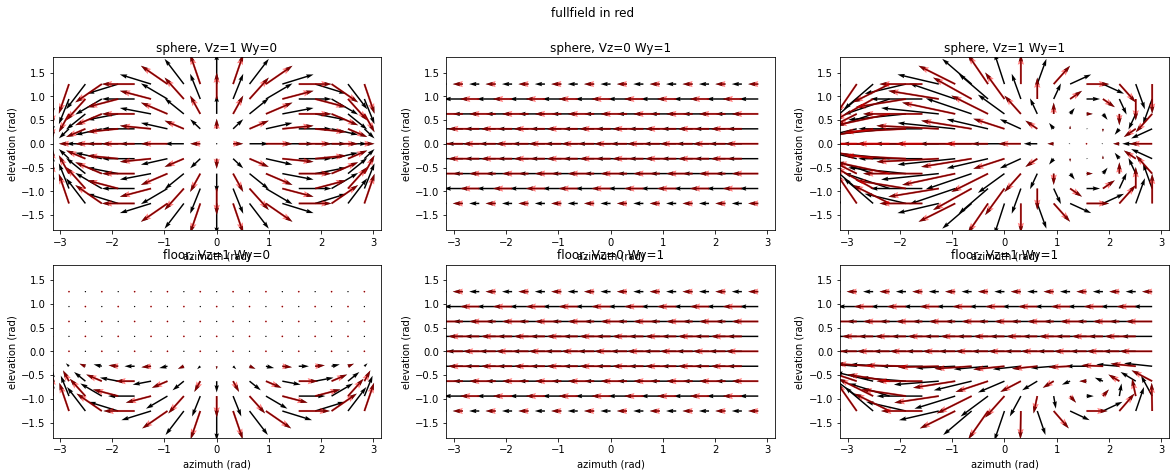

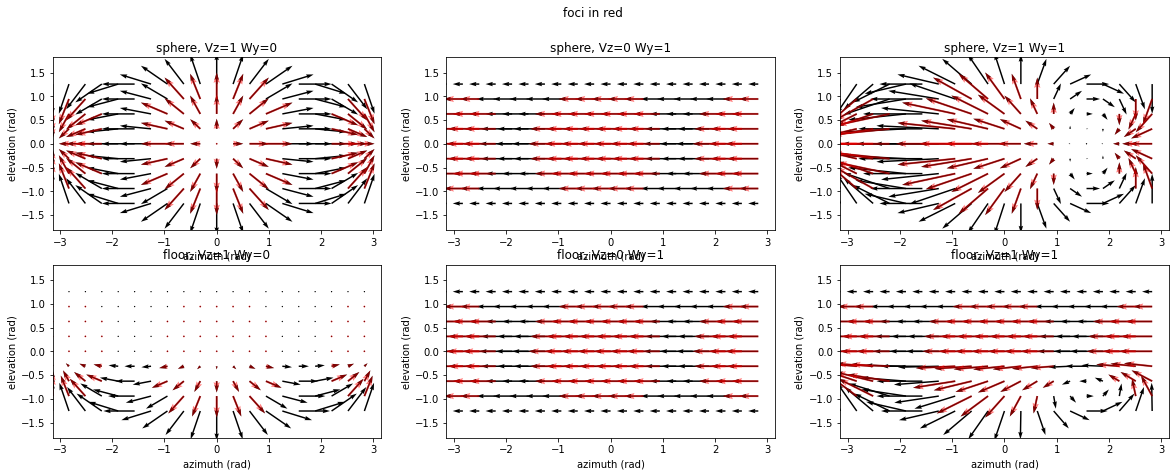

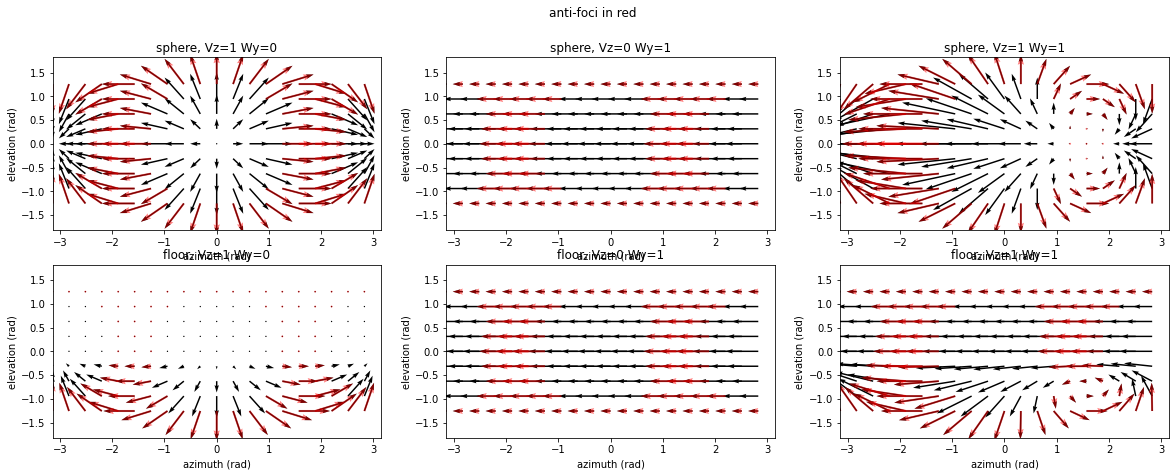

In [8]:
# show pre-defined samples on 3 velocities and 2 geometries

for t in range(len(inds_all)):
    plt.figure(figsize=(20,7))
    i=1
    for geometry in ['sphere','floor']:
        for Vz,Wy in [(1,0),(0,1),(1,1)]:
            
                this_subset_thetas = thetas[inds_all[t]]
                this_subset_alphas = alphas[inds_all[t]]
                
                plt.subplot(2,3,i)
                flow = tangentialflow(Vz=Vz,Wy=Wy,theta=thetas,alpha=alphas,geometry=geometry)
                plt.quiver(thetas,alphas,flow[0],flow[1],scale=10)
                plt.xlim(-np.pi,np.pi)
                plt.ylim(-np.pi/2,np.pi/2)
                plt.title(f'{geometry}, Vz={Vz} Wy={Wy}')
                #plt.axis('off')
                plt.xlabel('azimuth (rad)')
                plt.ylabel('elevation (rad)')
                plt.subplot(2,3,i)
                flow = tangentialflow(Vz=Vz,Wy=Wy,theta=this_subset_thetas,alpha=this_subset_alphas,geometry=geometry)
                plt.quiver(this_subset_thetas,this_subset_alphas,flow[0],flow[1],scale=10,color='r',alpha=.5)
                plt.xlim(-np.pi,np.pi)
                plt.ylim(-np.pi/2 - 0.25 ,np.pi/2 + 0.25)
                plt.title(f'{geometry}, Vz={Vz} Wy={Wy}')
                #plt.axis('off')
                plt.xlabel('azimuth (rad)')
                plt.ylabel('elevation (rad)')
                i += 1
    plt.suptitle(f'{thetatitles[t]} in red')

In [9]:
# for a given set of indices (x), runs a batch of self motion trajectories and calculates the errors
# x is a set of indices to use to subset theta/alpha
def error_calc(x,trials=10,noiselevel=0.05,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,plotit=False,spatvarnoise=False,weights=0):

    preds = np.nan*np.ones([trials,6])
    gt = np.nan*np.ones([trials,6])
    
    # subset
    this_subset_thetas = thetas[x]
    this_subset_alphas = alphas[x]

    for i in range(trials): 
        Vx,Vy,Vz,Wx,Wy,Wz = np.random.rand(6) # generate random behavior
        
        # zero out irrelevant DOFs
        if DOFs == 3:
            Vy = Wx = Wz = 0
        elif DOFs == 1:
            Vx = Vy = Wx = Wy = Wz = 0
            
        flow = tangentialflow(geometry=geometry,theta=this_subset_thetas,alpha=this_subset_alphas,Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz)
        _,h = np.shape(flow)
        noise = noiselevel*np.random.randn(2*h)
        noise = np.reshape(noise,[2,h])
        if spatvarnoise:
            noise = noise*((np.tile(this_subset_alphas,[2,1])+np.pi/2)/(np.pi))
        flow = flow + noise
        
        if plotit == True:
            plt.quiver(this_subset_thetas,this_subset_alphas,flow[0],flow[1],scale=10,color='r')
                
            plt.xlim(-np.pi,np.pi)
            plt.ylim(-np.pi/2 - 0.25,np.pi/2 + 0.25)
    
            plt.savefig(f'./plots/example_global_flow_{i}.eps', format='eps')
        
        # get error
        gt[i,:] = [Vx,Vy,Vz,Wx,Wy,Wz]
        preds[i,:] = getvel(flow,geometry=geometry,theta=this_subset_thetas,alpha=this_subset_alphas,DOFs=DOFs,weights=weights)
    
    # return average error (in meters or radians)
    errs = np.median(np.abs(preds-gt),0)
    err_Vz = errs[2]
    
    # heading error (in radians)
    headinggt = np.arctan2(gt[...,2],gt[...,0])
    headingpred = np.arctan2(preds[...,2],preds[...,0])
    headingerr = np.median(np.abs(anglediff(headingpred,headinggt,deg=False)))
    
    errs = np.append(errs,headingerr)
    
    #return err_Vz
    return errs

In [10]:
# run sim a bunch of times
def error_distribution(x,repeats=10,trials=10,noiselevel=0.05,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,plotit=False,spatvarnoise=False,weights=0):

    # initialize results        
    all_err         = np.zeros([repeats,7])

    for i in range(repeats):

        errs = error_calc(x,trials=trials,noiselevel=noiselevel,geometry=geometry,theta=theta,alpha=alpha,DOFs=DOFs,spatvarnoise=spatvarnoise,weights=weights)

        all_err[i,:] = errs
    return all_err


In [15]:
# run simulations and calculate distribution of errors - Vz

trials=1000
repeats=1000

inds = fullfield_inds
errors_fullfield = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
errors_fullfield = 100*errors_fullfield # convert to cm

inds = foci_inds
errors_foci = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
errors_foci = 100*errors_foci # convert to cm

inds = antifoci_inds
errors_antifoci = error_distribution(inds,repeats=repeats,trials=trials,noiselevel=0.25,geometry='sphere',theta=thetas,alpha=alphas,DOFs=6,spatvarnoise=False)
errors_antifoci = 100*errors_antifoci # convert to cm

np.savez('./global_median_error_files/histogram_median_errors.npz',errors_fullfield=errors_fullfield,errors_foci=errors_foci,errors_antifoci=errors_antifoci)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


best min 1.6080794385728319
worst max 2.83882392075572
full field mu =  2.0894291375408494  std =  0.07876810391471911
foci mu =  2.521408412703555  std =  0.09279256949840797
antifoci mu =  1.8255699330352904  std =  0.06863565155444558
effect size (D) anti to full -3.569873375045957
effect size (D) foci to full 5.016625200179171


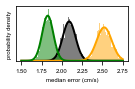

In [7]:
#Vz histograms

data = np.load('./global_median_error_files/histogram_median_errors.npz')
errors_fullfield = data['errors_fullfield']
errors_foci = data['errors_foci']
errors_antifoci = data['errors_antifoci']

font = {'family' : 'arial',
         'size'   : 6}

matplotlib.rc('font', **font)

# bounds
print('best min',np.min(errors_antifoci[:,2]))
print('worst max',np.max(errors_foci[:,2]))

xmin = np.min(errors_antifoci[:,2])
xmax = np.max(errors_foci[:,2])
xmin=1.5
xmax = 2.75
x = np.linspace(xmin, xmax, 100)

plt.figure(figsize=(2,1))


plt.hist(errors_fullfield[:,2],bins=x,label='full-field',alpha=0.5,density=True,color='k')
mu_fullfield, std_fullfield = norm.fit(errors_fullfield[:,2])
p = norm.pdf(x, mu_fullfield, std_fullfield)
plt.plot(x, p, 'k', linewidth=2)

print('full field mu = ',mu_fullfield,' std = ',std_fullfield)

plt.hist(errors_foci[:,2],bins=x,label='foci',alpha=0.5,density=True,color='orange')
mu_foci, std_foci = norm.fit(errors_foci[:,2])
p = norm.pdf(x, mu_foci, std_foci)
plt.plot(x, p, 'orange', linewidth=2)
print('foci mu = ',mu_foci,' std = ',std_foci)

plt.hist(errors_antifoci[:,2],bins=x,label='anti-foci',alpha=0.5,density=True,color='green')
mu_antifoci, std_antifoci = norm.fit(errors_antifoci[:,2])
p = norm.pdf(x, mu_antifoci, std_antifoci)
plt.plot(x, p, 'green', linewidth=2)
print('antifoci mu = ',mu_antifoci,' std = ',std_antifoci)

#plt.legend(prop={'size': 6})
plt.xlabel('median error (cm/s)')
plt.ylabel('probability density')

plt.yticks([])

# dprimes
print('effect size (D) anti to full',(mu_antifoci-mu_fullfield)/np.sqrt((np.std(errors_antifoci[:,2], ddof=1) ** 2 + np.std(errors_fullfield[:,2], ddof=1) ** 2) / 2.0) )
print('effect size (D) foci to full',(mu_foci-mu_fullfield)/np.sqrt((np.std(errors_foci[:,2], ddof=1) ** 2 + np.std(errors_fullfield[:,2], ddof=1) ** 2) / 2.0) )

plt.savefig(f'./final_plots/final_fig1_global_histogram_Vz.png', format='png',dpi=300)
plt.savefig(f'./final_plots/final_fig1_global_histogram_Vz.eps', format='eps',dpi=300)